In [1]:
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import getpass
import subprocess
import time
import importlib
from shutil import copy2

%load_ext autoreload
%autoreload 2

### Path to this cloned GitHub repo:
#SCRIPT_DIR = os.path.dirname(__file__)  # edit this to the GitHub repo path. Throws an error by default.

##### EDIT ######
SCRIPT_DIR = os.path.dirname('/home/ubuntu/data/heme_binder_diffusion_edit/scripts')  # edit this to the GitHub repo path. Throws an error by default.

          
assert os.path.exists(SCRIPT_DIR)
sys.path.append(SCRIPT_DIR+"/scripts/utils")
import utils

# De novo heme binding protein design pipeline using RFdiffusionAA
#### And other ligand binders too, I guess
Indrek Kalvet, PhD (Institute for Protein Design, University of Washington), ikalvet@uw.edu

As implemented in the publication "<i>Generalized Biomolecular Modeling and Design with RoseTTAFold All-Atom"

Link:

This notebook illustrates the design of heme-binding proteins, starting from minimal information (heme + substrate + CYS motif). It should work with minor modifications also for any other ligand.

The pipeline consists of 7 steps:<br>

    0) The protein backbones are generated with RFdiffusionAA
    1) Sequence is designed with proteinMPNN (without the ligand)
    2) Structures are predicted with AlphaFold2
    3) Ligand binding site is designed with LigandMPNN/FastRelax, or Rosetta FastDesign
    4) Sequences surrounding the ligand pocket are diversified with LigandMPNN
    5) Final designed sequences are predicted with AlphaFold2
    6) Alphafold2-predicted models are relaxed with the ligand and analyzed


## Paths of important Python scripts and programs

#### RFdiffusionAA:
Download RFdiffusionAA from here: https://github.com/baker-laboratory/rf_diffusion_all_atom

#### RFjoint inpainting (proteininpainting)
(Optional) Download RFjoint Inpainting here: https://github.com/RosettaCommons/RFDesign

Inpainting is used to further resample/diversify diffusion outputs, and it may also increase AF2 success rates.
<br>

#### AlphaFold2 and LigandMPNN
Other dependencies (ligandMPNN and AlphaFold2) are downloaded as submodules with this GitHub repository.

<br>
<br>
<i>After these evironments are set up and repositories are downloaded please provide paths to the inference scripts in the cell below:</i>

<br>
<br>

#### Python or Apptainer image
Please define in the cell below any Python executables or Apptainer image paths that are able to run the different scripts.<br>

This pipeline is tested to run based on two different Conda environments: `diffusion` and `mlfold`.<br>
Both of these can be set up based on the yml files provided by this repository.<br>
`mlfold` is used for AlphaFold2, and `diffusion` is used for everything else.

<br>

Alternatively, if your system is using Apptainers, you can set them up based on the same yml files, or do it separately. For RFdiffusionAA you can download this Apptainer image:
http://files.ipd.uw.edu/pub/RF-All-Atom/containers/rf_se3_diffusion.sif

If you are setting the environments or containers up without the provided YML files, then the minimum requirements for the different types are:<br>
`af2` Python needs to include jax=0.4.25 and jaxlib=0.4.23<br>
`proteinMPNN` Python needs to include pytorch and prody<br>
`general` Python needs to include pytorch, pyrosetta, prody<br>



In [2]:
##### EDIT ######
diffusion_script = "docker run -i --rm --privileged --gpus 1 -v /home/ubuntu/data/heme_binder_diffusion_edit/input:/input -v /home/ubuntu/data/heme_binder_diffusion_edit/output:/output rfdiffusion_aa apptainer run --bind /input:/input --bind /output:/output --nv rf_se3_diffusion.sif -u run_inference.py"  # edit this
inpaint_script = "PATH/TO/RFDesign/inpainting/inpaint.py"  # edit this if needed

##### Download and plant them from Github in lib folders #####
# proteinMPNN_script = f"docker run -i --rm --gpus 1 -v /home/jonas/Data/git/heme_binder_diffusion_edit/input:/input -v /home/jonas/Data/git/heme_binder_diffusion_edit/output:/output ligandmpnn python3 run.py"  # from submodule
proteinMPNN_script = f"{SCRIPT_DIR}/lib/LigandMPNN/run.py"
AF2_script = f"{SCRIPT_DIR}/scripts/af2/af2.py"  # from submodule
# Setup conda environment af2, proteinMPNN, general


### Python and/or Apptainer executables needed for running the jobs
### Please provide paths to executables that are able to run the different tasks.
### They can all be the same if you have an environment with all of the ncessary Python modules in one

# If your added Apptainer does not execute scripts directly,
# try adding 'apptainer run' or 'apptainer run --nv' (for GPU) in front of the command


##### EDIT ######
CONDAPATH = "/home/ubuntu/anaconda3"   # edit this depending on where your Conda environments live
PYTHON = {"diffusion": f"{CONDAPATH}/envs/diffusion/bin/python",  # NOT USED - hopefully
          "af2": f"{CONDAPATH}/envs/mlfold/bin/python",
          "proteinMPNN": f"{CONDAPATH}/envs/SE3nv_ln_pr/bin/python",
          "general": f"{CONDAPATH}/envs/SE3nv_ln_pr/bin/python"}  # Must be able to run LigandMPNN too...

## Project description and paths

In [3]:
username = getpass.getuser()  # your username on the running system
EMAIL = f"{username}@uw.edu"  # edit based on your organization. For Slurm job notifications.

PROJECT = "example_Heme_diffusion"

### Path where the jobs will be run and outputs dumped
WDIR = "/home/ubuntu/data/heme_binder_diffusion_edit/output"

if not os.path.exists(WDIR):
    os.makedirs(WDIR, exist_ok=True)

print(f"Working directory: {WDIR}")

USE_GPU_for_AF2 = True

Working directory: /home/ubuntu/data/heme_binder_diffusion_edit/output


In [4]:
# Ligand information
params = [f"{SCRIPT_DIR}/theozyme/HBA/HBA.params"]  # Rosetta params file(s)
LIGAND = "HBA"

## 0: Setting up diffusion run

In [9]:
# Using example PDB file with ligand HBA and protein 7o2g backbone.
## Note: the repository also contains additional HBA conformers with 7o2g and P450 motifs
## in the same directory as a ZIP file.

diffusion_inputs = glob.glob(f"{SCRIPT_DIR}/input/*.pdb")
print(f"Found {len(diffusion_inputs)} PDB files")

Found 1 PDB files


In [10]:
## Setting up general settings for diffusion

DIFFUSION_DIR = f"{WDIR}/0_diffusion"
if not os.path.exists(DIFFUSION_DIR):
    os.makedirs(DIFFUSION_DIR, exist_ok=False)

os.chdir(DIFFUSION_DIR)

N_designs = 240
T_steps = 200

## Edit this config based on motif residues, etc...
config = f"""
defaults:
  - aa

diffuser:
  T: {T_steps}

inference:
  num_designs: {N_designs}
  model_runner: NRBStyleSelfCond
  ligand: '{LIGAND}'

model:
  freeze_track_motif: True

contigmap:
  contigs: ["30-110,A15-15,30-110"]
  inpaint_str: null
  length: "100-140"

potentials:
  guiding_potentials: ["type:ligand_ncontacts,weight:1"] 
  guide_scale: 2
  guide_decay: cubic
"""

estimated_time = 3.5 * T_steps * N_designs  # assuming 3.5 seconds per timestep on A4000 GPU

print(f"Estimated time to produce {N_designs} designs = {estimated_time/60:.0f} minutes")
with open("config.yaml", "w") as file:
    file.write(config)
print(f"Wrote config file to {os.path.realpath('config.yaml')}")

Estimated time to produce 240 designs = 2800 minutes
Wrote config file to /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/config.yaml


In [11]:
## Setting up diffusion commands based on the input PDB file(s)
## Diffusion jobs are run in separate directories for each input PDB

commands_diffusion = []
cmds_filename = "commands_diffusion"
diffusion_rundirs = []
###### Original
"""
with open(cmds_filename, "w") as file:
    for p in diffusion_inputs:
        pdbname = os.path.basename(p).replace(".pdb", "")
        os.makedirs(pdbname, exist_ok=True)
        cmd = f"cd {pdbname} ; {PYTHON['diffusion']} {diffusion_script} --config-dir=../ "\
              f"--config-name=config.yaml inference.input_pdb={p} "\
              f"inference.output_prefix='./out/{pdbname}_dif' > output.log ; cd ..\n"
        commands_diffusion.append(cmd)
        diffusion_rundirs.append(pdbname)
        file.write(cmd)
"""
with open(cmds_filename, "w") as file:
    for p in diffusion_inputs:
        pdbname = os.path.basename(p).replace(".pdb", "")
        print(pdbname)
        os.makedirs(pdbname, exist_ok=True)
        cmd = f"#!/bin/bash\n{diffusion_script} --config-dir=/output/0_diffusion "\
              f"--config-name=config.yaml inference.input_pdb=/input/{pdbname}.pdb "\
              f"inference.output_prefix='/output/0_diffusion/{pdbname}/out/{pdbname}_dif' > {DIFFUSION_DIR}/{pdbname}/output.log"
        commands_diffusion.append(cmd)
        diffusion_rundirs.append(pdbname)
        file.write(cmd)

print(f"An example diffusion command that was generated:\n   {cmd}")


7o2g_HBA
An example diffusion command that was generated:
   #!/bin/bash
docker run -i --rm --privileged --gpus 1 -v /home/ubuntu/data/heme_binder_diffusion_edit/input:/input -v /home/ubuntu/data/heme_binder_diffusion_edit/output:/output rfdiffusion_aa apptainer run --bind /input:/input --bind /output:/output --nv rf_se3_diffusion.sif -u run_inference.py --config-dir=/output/0_diffusion --config-name=config.yaml inference.input_pdb=/input/7o2g_HBA.pdb inference.output_prefix='/output/0_diffusion/7o2g_HBA/out/7o2g_HBA_dif' > /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/7o2g_HBA/output.log


In [12]:
## Creating a Slurm submit script
## adjust time depending on number of designs and available hardware
submit_script = "submit_diffusion.sh"

####### Original
"""
utils.create_slurm_submit_script(filename=submit_script, name="diffusion_example", gpu=True, gres="gpu:a4000:1",
                                 mem="8g", N_cores=2, time="1:00:00", email=EMAIL,
                                 array=len(commands_diffusion), array_commandfile=cmds_filename)
print(f"Writing diffusion submission script to {submit_script}")
print(f"{len(commands_diffusion)} diffusion jobs to run")

if not os.path.exists(DIFFUSION_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()
"""

file_path = DIFFUSION_DIR+"/"+cmds_filename
print(DIFFUSION_DIR+"/.done")
print(file_path)

import stat
# Get the current permissions of the file
current_permissions = os.stat(file_path).st_mode
# Add execute permission for the owner
os.chmod(file_path, current_permissions | stat.S_IXUSR)

if not os.path.exists(DIFFUSION_DIR+"/.done"):
    print("Running...")
    # p = subprocess.Popen("bash " + file_path, shell=True)
    # p = subprocess.run(['bash'], stdin=file_path, shell=True)
    # with open(file_path, 'r') as file:
    #     subprocess.run(['bash'], stdin=file, shell=True)
    # subprocess.run(['bash', file_path], shell=True)
    p = subprocess.Popen(["bash", file_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()
    print(output)
    print(err)
    print("Done")
else:
    print("Done file found - skipping")

/home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/.done
/home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/commands_diffusion
Done file found - skipping


In [7]:
## If you're done with diffusion and happy with the outputs then mark it as done
DIFFUSION_DIR = f"{WDIR}/0_diffusion"
os.chdir(DIFFUSION_DIR)

if not os.path.exists(DIFFUSION_DIR+"/.done"):
    with open(f"{DIFFUSION_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")


### Analyzing diffusion outputs
The purpose of this step is to identify diffused backbones that meet certain quality criteria. These scaffolds should be relatively globular (measured by radius of gyration (rog), and longest helix). They should not have clashes between the ligand and the backbone, the ligand should not be too exposed (measured by relative SASA). The termini should not be too close to the ligand (term_mindist), and the backbone should not be too loopy. In the example below we are also looking for backbones that leave some part of the ligand more exposed.

In [13]:
### Analyzing diffusion outputs for clashes, ligand burial and scaffold quality
## If it's running too slowly consider increasing --nproc

analysis_script = f"{SCRIPT_DIR}/scripts/diffusion_analysis/process_diffusion_outputs.py"

diffusion_outputs = []
for d in diffusion_rundirs:
    diffusion_outputs += glob.glob(f"{DIFFUSION_DIR}/{d}/out/*.pdb")

# print(diffusion_outputs)

# By default I don't use the --analyze flag. As a result the backbones are filtered as the script runs.
# You can set --analyze to True to calculate all scores for all backbones.
# This will slow the analysis down, but you can then filter the backbones separately afterwards.
dif_analysis_cmd_dict = {"--pdb": " ".join(diffusion_outputs),
                        "--ref": f"{SCRIPT_DIR}/input/*.pdb",
                        "--params": " ".join(params),
                        "--term_limit": "15.0",
                        "--SASA_limit": "0.3",  # Highest allowed relative SASA of ligand
                        "--loop_limit": "0.4",  # Fraction of backbone that can be loopy
                        "--ref_catres": "A15",  # Position of CYS in diffusion input
                        "--rethread": True,
                        "--fix": True,
                        "--exclude_clash_atoms": "O1 O2 O3 O4 C5 C10",  # Ligand atoms excluded from clashchecking because they are flexible
                        "--ligand_exposed_atoms": "C45 C46 C47",  # Ligand atoms that need to be more exposed
                        "--exposed_atom_SASA": "10.0",  # minimum absolute SASA for exposed ligand atoms
                        "--longest_helix": "30",
                        "--rog": "30.0",
                        "--partial": None,
                        "--outdir": None,
                        "--traj": "5/30",  # Also random 5 models are taken from the last 30 steps of the diffusion trajectory
                        "--trb": None,
                        "--analyze": False,
                        # "--nproc": "1",
}

# analysis_command = f"{PYTHON['general']} {analysis_script}"
analysis_command = f"{PYTHON['general']} {analysis_script}"
for k, val in dif_analysis_cmd_dict.items():
    if val is not None:
        if isinstance(val, list):
            analysis_command += f" {k}"
            analysis_command += " " + " ".join(val)
        elif isinstance(val, bool):
            if val == True:
                analysis_command += f" {k}"
        else:
            analysis_command += f" {k} {val}"
        print(k, val)


print(analysis_command)

## Analyzing locally
p = subprocess.Popen(analysis_command, shell=True)
(output, err) = p.communicate()

diffused_backbones_good = glob.glob(f"{DIFFUSION_DIR}/filtered_structures/*.pdb")

dif_analysis_df = pd.read_csv(f"{DIFFUSION_DIR}/diffusion_analysis.sc", header=0, sep="\s+")



####### Original
"""
if len(diffusion_outputs) < 100:
    ## Analyzing locally
    p = subprocess.Popen(analysis_command, shell=True)
    (output, err) = p.communicate()
else:
    ## Too many structures to analyze.
    ## Running the analysis as a SLURM job.
    submit_script = "submit_diffusion_analysis.sh"
    utils.create_slurm_submit_script(filename=submit_script, name="diffusion_analysis",
                                     mem="8g", N_cores=dif_analysis_cmd_dict["--nproc"], time="0:20:00", email=EMAIL,
                                     command=analysis_command, outfile_name="output_analysis")

diffused_backbones_good = glob.glob(f"{DIFFUSION_DIR}/filtered_structures/*.pdb")

dif_analysis_df = pd.read_csv(f"{DIFFUSION_DIR}/diffusion_analysis.sc", header=0, sep="\s+")
"""
print()

--pdb /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/7o2g_HBA/out/7o2g_HBA_dif_75.pdb /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/7o2g_HBA/out/7o2g_HBA_dif_137.pdb /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/7o2g_HBA/out/7o2g_HBA_dif_9.pdb /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/7o2g_HBA/out/7o2g_HBA_dif_41.pdb /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/7o2g_HBA/out/7o2g_HBA_dif_77.pdb /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/7o2g_HBA/out/7o2g_HBA_dif_234.pdb /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/7o2g_HBA/out/7o2g_HBA_dif_65.pdb /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/7o2g_HBA/out/7o2g_HBA_dif_200.pdb /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/7o2g_HBA/out/7o2g_HBA_dif_165.pdb /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/7o2g_HBA/out/7o2g_HBA_dif_88.pdb /home/ubuntu/data/hem

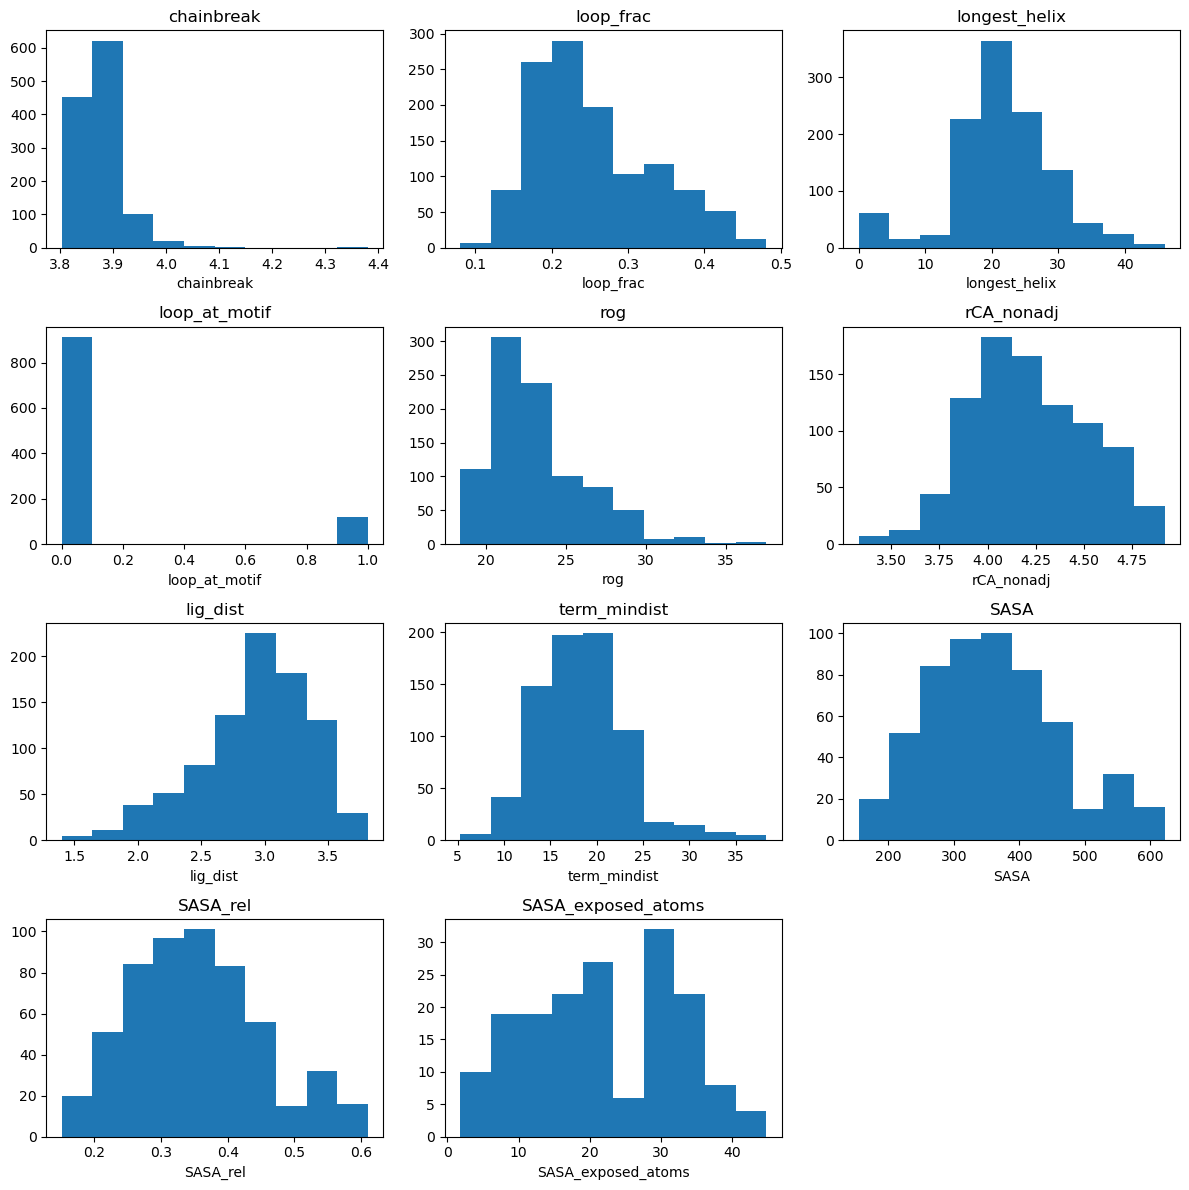

In [14]:
## Visualizing the distributions of diffusion analysis metrics
## Plotting design scores
plt.figure(figsize=(12, 12))
for i,k in enumerate(dif_analysis_df.keys()):
    if k in ["description"]:
        continue
    plt.subplot(4, 3, i+1)
    plt.hist(dif_analysis_df[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

It is highly advised that you manually inspect the filtered diffusion outputs before continuing with the pipeline.
While the filters attempt to pick out the most offending designs then nothing beats your own intuition and judgement.

If you would like to perform RFjoint Inpainting on the diffusion outputs, please go to the [inpainting section](#inpainting)

## 1: Running ProteinMPNN on diffused backbones

We are first trying to just design a sequence on the backbone, without considering the ligand.
The goal is to first find backbones that fold well.

In [15]:
diffused_backbones_good = glob.glob(f"{DIFFUSION_DIR}/filtered_structures/*.pdb")
assert len(diffused_backbones_good) > 0, "No good backbones found!"

os.chdir(WDIR)

MPNN_DIR = f"{WDIR}/1_proteinmpnn"
os.makedirs(MPNN_DIR, exist_ok=True)
os.chdir(MPNN_DIR)


### Parsing diffusion output TRB files to extract fixed motif residues
## These residues will not be redesigned with proteinMPNN
mask_json_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/make_maskdict_from_trb.py --out masked_pos.jsonl --trb"
for d in diffused_backbones_good:
    mask_json_cmd += " " + d.replace(".pdb", ".trb")

p = subprocess.Popen(mask_json_cmd, shell=True)
(output, err) = p.communicate()

assert os.path.exists("masked_pos.jsonl"), "Failed to create masked positions JSONL file"

# Read the file contents
with open("masked_pos.jsonl", 'r') as file:
    content = file.read()

# Replace all occurrences of "AAA" with "BBB"
updated_content = content.replace(WDIR, WDIR)

# Write the updated content back to the file
with open("masked_pos.jsonl", 'w') as file:
    file.write(updated_content)

In [16]:

### Setting up proteinMPNN run commands
## We're doing design with 3 temperatures, and 5 sequences each.
## This usually gives decent success with designable backbones.
## For more complicated cases consider doing >100 sequences.

MPNN_temperatures = [0.1, 0.2, 0.3]
MPNN_outputs_per_temperature = 5
MPNN_omit_AAs = "CM"


commands_mpnn = "#!/bin/bash\n"
cmds_filename_mpnn = "commands_mpnn"

with open(cmds_filename_mpnn, "w") as file:
    for T in MPNN_temperatures:
        for f in diffused_backbones_good:
            commands_mpnn += f"{PYTHON['proteinMPNN']} {proteinMPNN_script} "
            commands_mpnn += f"--model_type protein_mpnn --ligand_mpnn_use_atom_context 0 "
            commands_mpnn += "--fixed_residues_multi masked_pos.jsonl --out_folder . "
            commands_mpnn += f"--number_of_batches {MPNN_outputs_per_temperature} --temperature {T} "
            commands_mpnn += f"--omit_AA {MPNN_omit_AAs} --pdb_path {f} "
            commands_mpnn += f"--checkpoint_protein_mpnn {SCRIPT_DIR}/lib/LigandMPNN/model_params/proteinmpnn_v_48_020.pt\n"
    file.write(commands_mpnn)

print("Example MPNN command:")
print(commands_mpnn)


Example MPNN command:
#!/bin/bash
/home/ubuntu/anaconda3/envs/SE3nv_ln_pr/bin/python /home/ubuntu/data/heme_binder_diffusion_edit/lib/LigandMPNN/run.py --model_type protein_mpnn --ligand_mpnn_use_atom_context 0 --fixed_residues_multi masked_pos.jsonl --out_folder . --number_of_batches 5 --temperature 0.1 --omit_AA CM --pdb_path /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/filtered_structures/7o2g_HBA_dif_216_traj1.pdb --checkpoint_protein_mpnn /home/ubuntu/data/heme_binder_diffusion_edit/lib/LigandMPNN/model_params/proteinmpnn_v_48_020.pt
/home/ubuntu/anaconda3/envs/SE3nv_ln_pr/bin/python /home/ubuntu/data/heme_binder_diffusion_edit/lib/LigandMPNN/run.py --model_type protein_mpnn --ligand_mpnn_use_atom_context 0 --fixed_residues_multi masked_pos.jsonl --out_folder . --number_of_batches 5 --temperature 0.1 --omit_AA CM --pdb_path /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/filtered_structures/7o2g_HBA_dif_216_traj3.pdb --checkpoint_protein_mpnn /ho

In [ ]:
if not os.path.exists(MPNN_DIR+"/.done"):
    print("Running...")
    p = subprocess.Popen(["bash", cmds_filename_mpnn], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()
    print(output)
    print(err)
    print("Done")
else:
    print("Done file found - skipping")
    

In [18]:
## If you're done with diffusion and happy with the outputs then mark it as done
MPNN_DIR = f"{WDIR}/1_proteinmpnn"
os.chdir(MPNN_DIR)

if not os.path.exists(MPNN_DIR+"/.done"):
    with open(f"{MPNN_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")


## 2: Running AlphaFold2
Performing AF2 single sequence predictions.<br>
By default only using AF2 model 4 with 3 recycles. For more complicated folds 10+ recycles might be necessary.

In [19]:
os.chdir(WDIR)

AF2_DIR = f"{WDIR}/2_af2"
os.makedirs(AF2_DIR, exist_ok=True)
os.chdir(AF2_DIR)

### First collecting MPNN outputs and creating FASTA files for AF2 input
mpnn_fasta = utils.parse_fasta_files(glob.glob(f"{MPNN_DIR}/seqs/*.fa"))
mpnn_fasta = {k: seq.strip() for k, seq in mpnn_fasta.items() if "model_path" not in k}  # excluding the diffused poly-A sequence
# Giving sequences unique names based on input PDB name, temperature, and sequence identifier
mpnn_fasta = {k.split(",")[0]+"_"+k.split(",")[2].replace(" T=", "T")+"_0_"+k.split(",")[1].replace(" id=", ""): seq for k, seq in mpnn_fasta.items()}

print(f"A total on {len(mpnn_fasta)} sequences will be predicted.")

## Splitting the MPNN sequences based on length
## and grouping them in smaller batches for each AF2 job
## Use group size of >40 when running on GPU. Also depends on how many sequences and resources you have.

SEQUENCES_PER_AF2_JOB = 5  # CPU
if USE_GPU_for_AF2 is True:
    SEQUENCES_PER_AF2_JOB = 100  # GPU
mpnn_fasta_split = utils.split_fasta_based_on_length(mpnn_fasta, SEQUENCES_PER_AF2_JOB, write_files=True)


A total on 705 sequences will be predicted.
0 duplicate sequences removed.
100 sequences of 133 length.
30 sequences of 133 length.
25 sequences of 121 length.
25 sequences of 123 length.
25 sequences of 112 length.
50 sequences of 131 length.
25 sequences of 105 length.
35 sequences of 127 length.
25 sequences of 139 length.
20 sequences of 107 length.
35 sequences of 138 length.
50 sequences of 128 length.
20 sequences of 136 length.
30 sequences of 135 length.
20 sequences of 137 length.
25 sequences of 134 length.
35 sequences of 113 length.
85 sequences of 120 length.
25 sequences of 126 length.
5 sequences of 119 length.
15 sequences of 132 length.


In [20]:
## Setting up AlphaFold2 run

AF2_recycles = 3
AF2_models = "4"  # add other models to this string if needed, i.e. "3 4 5"

commands_af2 = """
#!/bin/sh
export CUDA_HOME=/usr/local/cuda-12
export PATH=$CUDA_HOME/bin:$PATH
export LD_LIBRARY_PATH=$CUDA_HOME/lib64:$LD_LIBRARY_PATH
"""
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2 += (f"{PYTHON['af2']} {AF2_script} ")
        commands_af2 += (f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} ")
        commands_af2 += (f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
    file.write(commands_af2)

if not os.path.exists(AF2_DIR+"/.done"):
    print("AF2 command:")
    print(commands_af2)
    p = subprocess.Popen(['bash', cmds_filename_af2], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()
    print(output)
    print(err)
    print('Done')
else:
    print("Skipping - Done")

##### Original
"""
commands_af2 = []
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2.append(f"{PYTHON['af2']} {AF2_script} "
                             f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} "
                             f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
        file.write(commands_af2[-1])

print("Example AF2 command:")
print(commands_af2[-1])

### Running AF2 with Slurm.
### Running jobs on the CPU. It takes ~10 minutes per sequence
### 

submit_script = "submit_af2.sh"
if USE_GPU_for_AF2 is True:
    utils.create_slurm_submit_script(filename=submit_script, name="2_af2", mem="6g", 
                                     N_cores=2, gpu=True, gres="gpu:rtx2080:1", time="00:12:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)
else:
    utils.create_slurm_submit_script(filename=submit_script, name="2_af2", mem="6g", 
                                     N_cores=4, time="01:00:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)

if not os.path.exists(AF2_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()
"""

print()


AF2 command:

#!/bin/sh
export CUDA_HOME=/usr/local/cuda-12
export PATH=$CUDA_HOME/bin:$PATH
export LD_LIBRARY_PATH=$CUDA_HOME/lib64:$LD_LIBRARY_PATH
/home/ubuntu/anaconda3/envs/mlfold/bin/python /home/ubuntu/data/heme_binder_diffusion_edit/scripts/af2/af2.py --af-nrecycles 3 --af-models 4 --fasta 134aa_0.fasta --scorefile 134aa_0.csv
/home/ubuntu/anaconda3/envs/mlfold/bin/python /home/ubuntu/data/heme_binder_diffusion_edit/scripts/af2/af2.py --af-nrecycles 3 --af-models 4 --fasta 132aa_0.fasta --scorefile 132aa_0.csv
/home/ubuntu/anaconda3/envs/mlfold/bin/python /home/ubuntu/data/heme_binder_diffusion_edit/scripts/af2/af2.py --af-nrecycles 3 --af-models 4 --fasta 120aa_0.fasta --scorefile 120aa_0.csv
/home/ubuntu/anaconda3/envs/mlfold/bin/python /home/ubuntu/data/heme_binder_diffusion_edit/scripts/af2/af2.py --af-nrecycles 3 --af-models 4 --fasta 131aa_0.fasta --scorefile 131aa_0.csv
/home/ubuntu/anaconda3/envs/mlfold/bin/python /home/ubuntu/data/heme_binder_diffusion_edit/scripts/af2

In [21]:
## If you're done with diffusion and happy with the outputs then mark it as done
AF2_DIR = f"{WDIR}/2_af2"
os.chdir(AF2_DIR)

if not os.path.exists(AF2_DIR+"/.done"):
    with open(f"{AF2_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")


### Analyzing AlphaFold2 predictions

In [22]:
# Combining all CSV scorefiles into one
AF2_DIR = f"{WDIR}/2_af2"
DIFFUSION_DIR = f"{WDIR}/0_diffusion"

os.system("head -n 1 $(ls *aa*.csv | shuf -n 1) > scores.csv ; for f in *aa*.csv ; do tail -n +2 ${f} >> scores.csv ; done")
assert os.path.exists("scores.csv"), "Could not combine scorefiles"

### Calculating the RMSDs of AF2 predictions relative to the diffusion outputs
### Catalytic residue sidechain RMSDs are calculated in the reference PDB has REMARK 666 line present

analysis_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/analyze_af2.py --scorefile scores.csv "\
               f"--ref_path {DIFFUSION_DIR}/filtered_structures/ --mpnn --params {' '.join(params)}"


### Clean up score.csv for repeating header rows
file_path = 'scores.csv'
lines = []

with open(file_path, 'r') as file:
    lines = file.readlines()

firstLine = True
with open(file_path, 'w') as file:
    for line in lines:
        if firstLine:
            firstLine = False
            file.write(line)
        else:
            if "ID,Name,Sequence,Model/Tag,Output_PDB,lDDT,Time" in line:
                pass
            else:
                file.write(line)

print(analysis_cmd)

# Analyzing locally
p = subprocess.Popen(analysis_cmd, shell=True)
(output, err) = p.communicate()
print(output)
print(err)
print('Done')

# if len(glob.glob(f"{AF2_DIR}/*.pdb")) < 100:
#     ## Analyzing locally
#     p = subprocess.Popen(analysis_cmd, shell=True)
#     (output, err) = p.communicate()
# else:
#     ## Running as a Slurm job
#     submit_script = "submit_af2_analysis.sh"
#     utils.create_slurm_submit_script(filename=submit_script, name="af2_analysis",
#                                      mem="16g", N_cores=8, time="0:20:00", email=EMAIL,
#                                      command=analysis_cmd, outfile_name="output_analysis")

#     p = subprocess.Popen(["sbatch", submit_script])
#     (output, err) = p.communicate()


/home/ubuntu/anaconda3/envs/SE3nv_ln_pr/bin/python /home/ubuntu/data/heme_binder_diffusion_edit/scripts/utils/analyze_af2.py --scorefile scores.csv --ref_path /home/ubuntu/data/heme_binder_diffusion_edit/output/0_diffusion/filtered_structures/ --mpnn --params /home/ubuntu/data/heme_binder_diffusion_edit/theozyme/HBA/HBA.params
Only calculating RMSD for predictions with lDDT >= 0.0
705 models with lDDT >= 0.0 to analyze.
┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│              See LICENSE.md or email license@uw.edu for details              │
└────────

lDDT                     >=  85.000: 64 items left. 64 pass (9%).
rmsd                     <=   1.500: 18 items left. 28 pass (4%).
rmsd_SR1                 <=   1.000: 1 items left. 7 pass (1%).


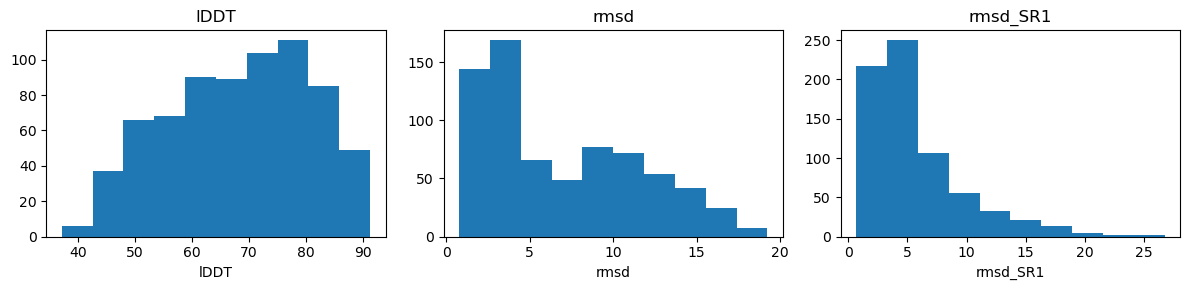

Plotting lDDT vs rmsd.


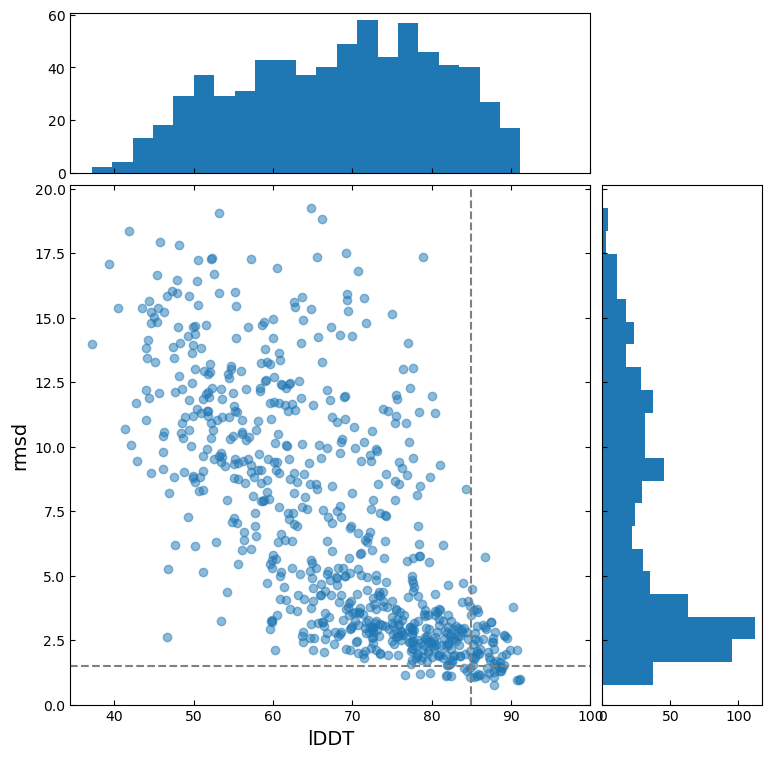

In [23]:
scores_af2 = pd.read_csv("scores.sc", sep="\s+", header=0)

## Filtering AF2 scores based on lddt and rmsd
# Define your desired cutoffs here:
AF2_filters = {"lDDT": [85.0, ">="],
               "rmsd": [1.5, "<="],
               "rmsd_SR1": [1.0, "<="]}  # 1st catalytic residue sc-rmsd


scores_af2_filtered = utils.filter_scores(scores_af2, AF2_filters)
utils.dump_scorefile(scores_af2_filtered, "filtered_scores.sc")

## Plotting AF2 scores
plt.figure(figsize=(12, 3))
for i,k in enumerate(AF2_filters):
    plt.subplot(1, 3, i+1)
    plt.hist(scores_af2[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()
    
utils.plot_score_pairs(scores_af2, "lDDT", "rmsd", AF2_filters["lDDT"][0], AF2_filters["rmsd"][0])

In [24]:
### Copying good predictions to a separate directory
os.chdir(AF2_DIR)

if len(scores_af2_filtered) > 0:
    os.makedirs("good", exist_ok=True)
    good_af2_models = [row["Output_PDB"]+".pdb" for idx,row in scores_af2_filtered.iterrows()]
    for pdb in good_af2_models:
        copy2(pdb, f"good/{pdb}")
    good_af2_models = glob.glob(f"{AF2_DIR}/good/*.pdb")
else:
    sys.exit("No good models to continue this pipeline with")

os.chdir(f"{AF2_DIR}/good")


### Aligning the ligand back into the AF2 predictions.
### This is done by aligning the AF2 model to diffusion output and copying over the ligand using PyRosetta.
### --fix_catres option will readjust the rotamer and tautomer of 
### any catalytic residue to be the same as in the reference model.

align_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/place_ligand_after_af2.py "\
            f"--outdir with_heme --params {' '.join(params)} --fix_catres "\
            f"--pdb {' '.join(good_af2_models)} "\
            f"--ref {' '.join(glob.glob(DIFFUSION_DIR+'/filtered_structures/*.pdb'))}"

p = subprocess.Popen(align_cmd, shell=True)
(output, err) = p.communicate()

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│              See LICENSE.md or email license@uw.edu for details              │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.ubuntu.cxx11thread.serialization 2024.10+release.2c36cbc7108d85646ca5b8ddc89c29ac1ccde88e 2024-03-01T16:53:36] retrieved from: http://www.pyrosetta.org
/home/ubuntu/data/heme_binder_diffusion_edit/output/2_af2/good/7o2g_HBA_dif_130_traj2_T0.3_0_5_model_4.0_r3_af2.pdb: alignment RMSD = 0.944
/home/

## 3.1: Performing binding site design with ligandMPNN / FastRelax
(see 3.2 down below for design with [Rosetta FastDesign](#Rosetta_design))

In [28]:
### Setting up design directory and commands
os.chdir(WDIR)
DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_design_pocket_ligandMPNN"
os.makedirs(DESIGN_DIR_ligMPNN, exist_ok=True)
os.chdir(DESIGN_DIR_ligMPNN)

AF2_DIR = f"{WDIR}/2_af2"
os.makedirs(DESIGN_DIR_ligMPNN+"/logs", exist_ok=True)

### Performing 5 design iterations on each input structure
NSTRUCT = 10
cstfile = f"{SCRIPT_DIR}/theozyme/HBA/HBA_CYS_UPO.cst"

commands_design = "#!/bin/bash\n"
cmds_filename_des = "commands_design"

print(f"{AF2_DIR}/good/with_heme")


with open(cmds_filename_des, "w") as file:
    for pdb in glob.glob(f"{AF2_DIR}/good/with_heme/*.pdb"):
        commands_design += f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/heme_pocket_ligMPNN.py "
        commands_design += f"--pdb {pdb} --nstruct {NSTRUCT} "
        commands_design += f"--scoring {SCRIPT_DIR}/scripts/design/scoring/heme_scoring.py "
        commands_design += f"--params {' '.join(params)} --cstfile {cstfile} > logs/{os.path.basename(pdb).replace('.pdb', '.log')}\n"
    file.write(commands_design)

print("Design command:")
print(commands_design)

if not os.path.exists(DESIGN_DIR_ligMPNN+"/.done"):
    print('Running')
    p = subprocess.Popen(['bash', cmds_filename_des], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()
    print('Done')
else:
    print('Found done file - Skipping')


# ### Running design jobs with Slurm.
# submit_script = "submit_design.sh"
# utils.create_slurm_submit_script(filename=submit_script, name="3.1_design_pocket_ligMPNN", mem="4g", 
#                                  N_cores=1, time="3:00:00", email=EMAIL, array=len(commands_design),
#                                  array_commandfile=cmds_filename_des)

# if not os.path.exists(DESIGN_DIR_ligMPNN+"/.done"):
#     p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     (output, err) = p.communicate()

/home/ubuntu/data/heme_binder_diffusion_edit/output/2_af2/good/with_heme
Design command:
#!/bin/bash
/home/ubuntu/anaconda3/envs/SE3nv_ln_pr/bin/python /home/ubuntu/data/heme_binder_diffusion_edit/scripts/design/heme_pocket_ligMPNN.py --pdb /home/ubuntu/data/heme_binder_diffusion_edit/output/2_af2/good/with_heme/7o2g_HBA_dif_130_traj2_T0.3_0_5_model_4.0_r3_af2_HBA.pdb --nstruct 10 --scoring /home/ubuntu/data/heme_binder_diffusion_edit/scripts/design/scoring/heme_scoring.py --params /home/ubuntu/data/heme_binder_diffusion_edit/theozyme/HBA/HBA.params --cstfile /home/ubuntu/data/heme_binder_diffusion_edit/theozyme/HBA/HBA_CYS_UPO.cst > logs/7o2g_HBA_dif_130_traj2_T0.3_0_5_model_4.0_r3_af2_HBA.log

Running


KeyboardInterrupt: 

In [26]:
## If you're done with design and happy with the outputs then mark it as done
DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_design_pocket_ligandMPNN"
os.chdir(DESIGN_DIR_ligMPNN)

if not os.path.exists(DESIGN_DIR_ligMPNN+"/.done"):
    with open(f"{DESIGN_DIR_ligMPNN}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing ligMPNN / FastRelax design results

In [ ]:
## Analyzing ligMPNN / FastRelax designs
if not os.path.exists("scorefile.txt"):
    sys.exit("Design job failed, or no successful outputs were produced.")

scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {'all_cst': [1.0, '<='],
 'nlr_SR1_rms': [0.8, '<='],
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'COO_hbond': [1.0, '='],
 'heme_angle_wrst': [80.0, '>='],
 'score_per_res': [0.0, '<='],
 'corrected_ddg': [-50.0, '<='],
 'cms_per_atom': [4.8, '>=']}

filtered_scores = utils.filter_scores(scores, filters)

## Plotting AF2 scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    plt.subplot(3, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{DESIGN_DIR_ligMPNN}/good")
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

## 4.1 Performing ligandMPNN redesign on the 2nd layer residues

Resampling residues that are not in the pocket, but also not very far from the pocket

In [ ]:
if len(glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb')) == 0:
    sys.exit("No designs to run 2nd MPNN on.")

os.chdir(WDIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.1_2nd_mpnn"
os.makedirs(DESIGN_DIR_2nd_mpnn, exist_ok=True)
os.chdir(DESIGN_DIR_2nd_mpnn)

### Making a JSON file specifiying designable positions for each structure.
### Will also make non-pocket ALA positions as designable.
### This is to fix any surface ALA-patches that previous MPNN may have introduced.

make_json_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/setup_ligand_mpnn_2nd_layer.py "\
                f"--params {' '.join(params)} --ligand {LIGAND} --output_path parsed_pdbs_lig.jsonl "\
                 "--output_path masked_pos.jsonl --dist_bb 6.0 --dist_sc 5.0 "\
                f"--pdb {' '.join(glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb'))}"

p = subprocess.Popen(make_json_cmd, shell=True)
(output, err) = p.communicate()


### Setting up ligandMPNN run commands
## We're doing design with 2 temperatures (more conservative than before), and 5 sequences each.

MPNN_temperatures = [0.1, 0.2]
MPNN_outputs_per_temperature = 5
MPNN_omit_AAs = "CM"

commands_mpnn = []
cmds_filename_mpnn = "commands_mpnn"
with open(cmds_filename_mpnn, "w") as file:
    for T in MPNN_temperatures:
        for f in glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb'):
            commands_mpnn.append(f"{PYTHON['proteinMPNN']} {proteinMPNN_script} "
                                 f"--model_type ligand_mpnn --ligand_mpnn_use_atom_context 1 "
                                 "--fixed_residues_multi masked_pos.jsonl --out_folder ./ "
                                 f"--number_of_batches {MPNN_outputs_per_temperature} --temperature {T} "
                                 f"--omit_AA {MPNN_omit_AAs} --pdb_path {f}"
                                 f"--checkpoint_protein_mpnn {SCRIPT_DIR}/lib/LigandMPNN/model_params/ligandmpnn_v_32_010_25.pt\n")
            file.write(commands_mpnn[-1])

print("Example MPNN command:")
print(commands_mpnn[-1])

### Running ligandMPNN with Slurm.
### Grouping jobs with 10 commands per one array job.

submit_script = "submit_mpnn.sh"
utils.create_slurm_submit_script(filename=submit_script, name="4.1_2nd_mpnn", mem="8g", 
                                 N_cores=1, time="0:15:00", email=EMAIL, array=len(commands_mpnn),
                                 array_commandfile=cmds_filename_mpnn, group=10)

if not os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()


## 5.1 AlphaFold2 predictions on the 2nd MPNN run

In [ ]:
os.chdir(WDIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.1_2nd_mpnn"
assert os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"), "2nd MPNN has not been performed!"

AF2_DIR = f"{WDIR}/5.1_2nd_af2"
os.makedirs(AF2_DIR, exist_ok=True)
os.chdir(AF2_DIR)

### First collecting MPNN outputs and creating FASTA files for AF2 input
mpnn_fasta = utils.parse_fasta_files(glob.glob(f"{DESIGN_DIR_2nd_mpnn}/seqs/*.fa"))
# Giving sequences unique names based on input PDB name, temperature, and sequence identifier
_mpnn_fasta = {}
for k, seq in mpnn_fasta.items():
    if "model_path" in k:
        _mpnn_fasta[k.split(",")[0]+"_native"] = seq.strip()
    else:
        _mpnn_fasta[k.split(",")[0]+"_"+k.split(",")[2].replace(" T=", "T")+"_0_"+k.split(",")[1].replace(" id=", "")] = seq.strip()
mpnn_fasta = {k:v for k,v in _mpnn_fasta.items()}

print(f"A total on {len(mpnn_fasta)} sequences will be predicted.")

## Splitting the MPNN sequences based on length
## and grouping them in smaller batches for each AF2 job
## Use group size of >40 when running on GPU. Also depends on how many sequences and resources you have.
SEQUENCES_PER_AF2_JOB = 5  # CPU
if USE_GPU_for_AF2 is True:
    SEQUENCES_PER_AF2_JOB = 100  # GPU
mpnn_fasta_split = utils.split_fasta_based_on_length(mpnn_fasta, SEQUENCES_PER_AF2_JOB, write_files=True)


In [ ]:
## Setting up AlphaFold2 run

AF2_recycles = 3
AF2_models = "4"  # add other models to this string if needed

commands_af2 = []
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2.append(f"{PYTHON['af2']} {AF2_script} "
                             f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} "
                             f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
        file.write(commands_af2[-1])

print("Example AF2 command:")
print(commands_af2[-1])

### Running AF2 with Slurm.
### Running jobs on the CPU. It takes ~10 minutes per sequence

submit_script = "submit_af2.sh"
if USE_GPU_for_AF2 is True:
    utils.create_slurm_submit_script(filename=submit_script, name="5.1_2nd_af2", mem="6g", 
                                     N_cores=2, gpu=True, gres="gpu:rtx2080:1", time="00:12:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)
else:
    utils.create_slurm_submit_script(filename=submit_script, name="5.1_2nd_af2", mem="6g", 
                                     N_cores=4, time="01:00:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)

if not os.path.exists(AF2_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with AF2 and happy with the outputs then mark it as done
AF2_DIR = f"{WDIR}/5.1_2nd_af2"
os.chdir(AF2_DIR)
DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_design_pocket_ligandMPNN"

if not os.path.exists(AF2_DIR+"/.done"):
    with open(f"{AF2_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing AlphaFold2 predictions

In [ ]:
# Combining all CSV scorefiles into one
os.system("head -n 1 $(ls *aa*.csv | shuf -n 1) > scores.csv ; for f in *aa*.csv ; do tail -n +2 ${f} >> scores.csv ; done")
assert os.path.exists("scores.csv"), "Could not combine scorefiles"

### Calculating the RMSDs of AF2 predictions relative to the diffusion outputs
### Catalytic residue sidechain RMSDs are calculated in the reference PDB has REMARK 666 line present

analysis_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/analyze_af2.py --scorefile scores.csv "\
               f"--ref_path {DESIGN_DIR_ligMPNN}/good/ --mpnn --params {' '.join(params)}"

p = subprocess.Popen(analysis_cmd, shell=True)
(output, err) = p.communicate()


In [ ]:
### Visualizing and filtering AF2 results
AF2_DIR = f"{WDIR}/5.1_2nd_af2"
os.chdir(AF2_DIR)

scores_af2 = pd.read_csv("scores.sc", sep="\s+", header=0)

### Filtering AF2 scores based on lddt and rmsd
# Define your desired cutoffs here:
AF2_filters = {"lDDT": [85.0, ">="],
               "rmsd": [1.2, "<="],
               "rmsd_SR1": [1.0, "<="]}  # 1st catalytic residue sc-rmsd

scores_af2_filtered = utils.filter_scores(scores_af2, AF2_filters)
utils.dump_scorefile(scores_af2_filtered, "filtered_scores.sc")

## Plotting AF2 scores
plt.figure(figsize=(12, 3))
for i,k in enumerate(AF2_filters):
    plt.subplot(1, 3, i+1)
    plt.hist(scores_af2[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

utils.plot_score_pairs(scores_af2, "lDDT", "rmsd", AF2_filters["lDDT"][0], AF2_filters["rmsd"][0])

In [ ]:
### Copying good predictions to a separate directory
os.chdir(AF2_DIR)

if len(scores_af2_filtered) > 0:
    os.makedirs("good", exist_ok=True)
    good_af2_models = [row["Output_PDB"]+".pdb" for idx,row in scores_af2_filtered.iterrows()]
    for pdb in good_af2_models:
        copy2(pdb, f"good/{pdb}")
    good_af2_models = glob.glob(f"{AF2_DIR}/good/*.pdb")
else:
    sys.exit("No good models to continue this pipeline with")


## 6.1: Final FastRelax with the ligand
Relaxing good AF2 models together with the ligand

In [ ]:
AF2_DIR = f"{WDIR}/5.1_2nd_af2"
DESIGN_DIR_ligMPNN = f"{WDIR}/3.1_design_pocket_ligandMPNN"
assert len(glob.glob(f"{AF2_DIR}/good/*.pdb")) > 0, "No good AF2 models to relax with"

os.chdir(WDIR)
RELAX_DIR = f"{WDIR}/6.1_final_relax"
os.makedirs(RELAX_DIR, exist_ok=True)
os.chdir(RELAX_DIR)

os.makedirs(RELAX_DIR+"/logs", exist_ok=True)

## First matching up the AF2 output filenames of step 5 with pocket design filenames from step 3
ref_and_model_pairs = []
for r in glob.glob(f"{DESIGN_DIR_ligMPNN}/good/*.pdb"):
    for pdbfile in glob.glob(f"{AF2_DIR}/good/*.pdb"):
        if os.path.basename(r).replace(".pdb", "_") in pdbfile:
            ref_and_model_pairs.append((r, pdbfile))

assert len(ref_and_model_pairs) == len(glob.glob(f"{AF2_DIR}/good/*.pdb")), "Was not able to match all models with reference structures"


## Generating commands for relax jobs
### Performing 1 relax iteration on each input structure
NSTRUCT = 1
cstfile = f"{SCRIPT_DIR}/theozyme/HBA/HBA_CYS_UPO.cst"

commands_relax = []
cmds_filename_rlx = "commands_relax"
with open(cmds_filename_rlx, "w") as file:
    for r_m in ref_and_model_pairs:
        commands_relax.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/align_add_ligand_relax.py "
                              f"--outdir ./ --ligand {LIGAND} --ref_pdb {r_m[0]} "
                              f"--pdb {r_m[1]} --nstruct {NSTRUCT} "
                              f"--params {' '.join(params)} --cstfile {cstfile} > logs/{os.path.basename(r_m[1]).replace('.pdb', '.log')}\n")
        file.write(commands_relax[-1])

print("Example design command:")
print(commands_relax[-1])


### Running design jobs with Slurm.
submit_script = "submit_relax.sh"
utils.create_slurm_submit_script(filename=submit_script, name="6.1_final_relax", mem="4g", 
                                 N_cores=1, time="0:30:00", email=EMAIL, array=len(commands_relax),
                                 array_commandfile=cmds_filename_rlx)

if not os.path.exists(RELAX_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with final relax and happy with the outputs then mark it as done
RELAX_DIR = f"{WDIR}/6.1_final_relax"
os.chdir(RELAX_DIR)

if not os.path.exists(RELAX_DIR+"/.done"):
    with open(f"{RELAX_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing final relaxed structures
Filtering them based on the same metrics as was used for the initial design

In [ ]:
## Analyzing Rosetta designs
RELAX_DIR = f"{WDIR}/6.1_final_relax"
os.chdir(RELAX_DIR)

scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {'all_cst': [1.0, '<='],
 'nlr_SR1_rms': [0.8, '<='],
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'COO_hbond': [1.0, '='],
 'heme_angle_wrst': [80.0, '>='],
 'score_per_res': [0.0, '<='],
 'corrected_ddg': [-50.0, '<='],
 'cms_per_atom': [4.8, '>='],
 'rmsd_CA_rlx_in': [1.0, "<="]}  # rmsd_CA_rlx_in is rmsd between relaxed structure and AF2 prediction

filtered_scores = utils.filter_scores(scores, filters)

## Plotting relax scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    if k not in scores.keys():
        continue
    plt.subplot(4, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{RELAX_DIR}/good", exist_ok=True)
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

In [ ]:
if len(filtered_scores) > 0:
    print(f"CONGRATULATIONS! You have successfully designed {len(filtered_scores)} proteins against ligand {LIGAND}")
    print("You can find the design models in the directory:\n"
          f"    {RELAX_DIR}/good")
    print("\nIt is advised you manually inspect them before ordering.")

## 
## --------------------------------------------------------------------------------------------------------------------

<i>The following part of the pipeline branches off after the first AlphaFold2 step (2)

## 3.2: Performing binding site design with Rosetta FastDesign
<a id='Rosetta_design'></a>

In [ ]:
### Setting up design directory and commands
os.chdir(WDIR)
DESIGN_DIR_ROSETTA = f"{WDIR}/3.2_design_pocket_Rosetta"
os.makedirs(DESIGN_DIR_ROSETTA, exist_ok=True)
os.chdir(DESIGN_DIR_ROSETTA)
AF2_DIR = f"{WDIR}/2_af2"

os.makedirs(DESIGN_DIR_ROSETTA+"/logs", exist_ok=True)

### Performing 5 design iterations on each input structure
NSTRUCT = 5
cstfile = f"{SCRIPT_DIR}/theozyme/HBA/HBA_CYS_UPO.cst"

commands_design = []
cmds_filename_des = "commands_design"
with open(cmds_filename_des, "w") as file:
    for pdb in glob.glob(f"{AF2_DIR}/good/with_heme/*.pdb"):
        commands_design.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/heme_pocket_FastDesign.py "
                             f"--pdb {pdb} --norelax --nstruct {NSTRUCT} "
                             f"--params {' '.join(params)} --cstfile {cstfile} > logs/{os.path.basename(pdb).replace('.pdb', '.log')}\n")
        file.write(commands_design[-1])

print("Example design command:")
print(commands_design[-1])


### Running design jobs with Slurm.
submit_script = "submit_design.sh"
utils.create_slurm_submit_script(filename=submit_script, name="3.2_design_pocket_Rosetta", mem="4g", 
                                 N_cores=1, time="3:00:00", email=EMAIL, array=len(commands_design),
                                 array_commandfile=cmds_filename_des)

if not os.path.exists(DESIGN_DIR_ROSETTA+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with design and happy with the outputs then mark it as done
DESIGN_DIR_ROSETTA = f"{WDIR}/3.2_design_pocket_Rosetta"
os.chdir(DESIGN_DIR_ROSETTA)

if not os.path.exists(DESIGN_DIR_ROSETTA+"/.done"):
    with open(f"{DESIGN_DIR_ROSETTA}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

In [ ]:
## Analyzing Rosetta designs
scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {'all_cst': [1.0, '<='],
 'nlr_SR1_rms': [0.8, '<='],
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'COO_hbond': [1.0, '='],
 'heme_angle_wrst': [80.0, '>='],
 'score_per_res': [0.0, '<='],
 'corrected_ddg': [-50.0, '<='],
 'cms_per_atom': [4.8, '>=']}

filtered_scores = utils.filter_scores(scores, filters)

## Plotting AF2 scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    plt.subplot(3, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{DESIGN_DIR_ROSETTA}/good", exist_ok=True)
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

## 4.2 Performing ligandMPNN redesign on the 2nd layer residues

Resampling residues that are not in the pocket, but also not very far from the pocket

In [ ]:
if len(glob.glob(DESIGN_DIR_ROSETTA+'/good/*.pdb')) == 0:
    sys.exit("No designs to run 2nd MPNN on.")

os.chdir(WDIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.2_2nd_mpnn"
os.makedirs(DESIGN_DIR_2nd_mpnn, exist_ok=True)
os.chdir(DESIGN_DIR_2nd_mpnn)

### Making a JSON file specifiying designable positions for each structure.
### Will also make non-pocket ALA positions as designable.
### This is to fix any surface ALA-patches that previous MPNN may have introduced.

make_json_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/setup_ligand_mpnn_2nd_layer.py "\
                f"--params {' '.join(params)} --ligand {LIGAND} --output_path parsed_pdbs_lig.jsonl "\
                 "--output_path masked_pos.jsonl --dist_bb 6.0 --dist_sc 5.0 "\
                f"--pdb {' '.join(glob.glob(DESIGN_DIR_ROSETTA+'/good/*.pdb'))}"

p = subprocess.Popen(make_json_cmd, shell=True)
(output, err) = p.communicate()


### Setting up ligandMPNN run commands
## We're doing design with 2 temperatures (more conservative than before), and 5 sequences each.

MPNN_temperatures = [0.1, 0.2]
MPNN_outputs_per_temperature = 5
MPNN_omit_AAs = "CM"

commands_mpnn = []
cmds_filename_mpnn = "commands_mpnn"
with open(cmds_filename_mpnn, "w") as file:
    for T in MPNN_temperatures:
        for f in glob.glob(DESIGN_DIR_ROSETTA+'/good/*.pdb'):
            commands_mpnn.append(f"{PYTHON['proteinMPNN']} {proteinMPNN_script} "
                                 f"--model_type ligand_mpnn --ligand_mpnn_use_atom_context 1 "
                                 "--fixed_residues_multi masked_pos.jsonl --out_folder ./ "
                                 f"--number_of_batches {MPNN_outputs_per_temperature} --temperature {T} "
                                 f"--omit_AA {MPNN_omit_AAs} --pdb_path {f} "
                                 f"--checkpoint_protein_mpnn {SCRIPT_DIR}/lib/LigandMPNN/model_params/ligandmpnn_v_32_010_25.pt\n")
            file.write(commands_mpnn[-1])

print("Example MPNN command:")
print(commands_mpnn[-1])


### Running ligandMPNN with Slurm.
### Grouping jobs with 10 commands per one array job.
submit_script = "submit_mpnn.sh"
utils.create_slurm_submit_script(filename=submit_script, name="4.2_2nd_mpnn", mem="8g", 
                                 N_cores=1, time="0:15:00", email=EMAIL, array=len(commands_mpnn),
                                 array_commandfile=cmds_filename_mpnn, group=10)

if not os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()


In [ ]:
## If you're done with design and happy with the outputs then mark it as done
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.2_2nd_mpnn"
os.chdir(DESIGN_DIR_2nd_mpnn)

if not os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"):
    with open(f"{DESIGN_DIR_2nd_mpnn}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

## 5.2 AlphaFold2 predictions on the 2nd MPNN run

In [ ]:
os.chdir(WDIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.2_2nd_mpnn"
assert os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"), "2nd MPNN has not been performed!"

AF2_DIR = f"{WDIR}/5.2_2nd_af2"
os.makedirs(AF2_DIR, exist_ok=True)
os.chdir(AF2_DIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/4.2_2nd_mpnn"

### First collecting MPNN outputs and creating FASTA files for AF2 input
mpnn_fasta = utils.parse_fasta_files(glob.glob(f"{DESIGN_DIR_2nd_mpnn}/seqs/*.fa"))
# Giving sequences unique names based on input PDB name, temperature, and sequence identifier
_mpnn_fasta = {}
for k, seq in mpnn_fasta.items():
    if "model_path" in k:
        _mpnn_fasta[k.split(",")[0]+"_native"] = seq.strip()
    else:
        _mpnn_fasta[k.split(",")[0]+"_"+k.split(",")[2].replace(" T=", "T")+"_0_"+k.split(",")[1].replace(" id=", "")] = seq.strip()
mpnn_fasta = {k:v for k,v in _mpnn_fasta.items()}

print(f"A total on {len(mpnn_fasta)} sequences will be predicted.")

## Splitting the MPNN sequences based on length
## and grouping them in smaller batches for each AF2 job
## Use group size of >40 when running on GPU. Also depends on how many sequences and resources you have.

SEQUENCES_PER_AF2_JOB = 5  # CPU
if USE_GPU_for_AF2 is True:
    SEQUENCES_PER_AF2_JOB = 100  # GPUSEQUENCES_PER_AF2_JOBSEQUENCES_PER_AF2_JOBSEQUENCES_PER_AF2_JOB
mpnn_fasta_split = utils.split_fasta_based_on_length(mpnn_fasta, SEQUENCES_PER_AF2_JOB, write_files=True)


In [ ]:
## Setting up AlphaFold2 run

AF2_recycles = 3
AF2_models = "4"  # add other models to this string if needed

commands_af2 = []
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2.append(f"{PYTHON['af2']} {AF2_script} "
                             f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} "
                             f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
        file.write(commands_af2[-1])

print("Example AF2 command:")
print(commands_af2[-1])


### Running AF2 with Slurm.

submit_script = "submit_af2.sh"

if USE_GPU_for_AF2 is True:
    utils.create_slurm_submit_script(filename=submit_script, name="5.2_2nd_af2", mem="6g", 
                                     N_cores=2, gpu=True, gres="gpu:rtx2080:1", time="00:12:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)
else:
    utils.create_slurm_submit_script(filename=submit_script, name="5.2_2nd_af2", mem="6g", 
                                     N_cores=4, time="01:00:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)

if not os.path.exists(AF2_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with AF2 and happy with the outputs then mark it as done
AF2_DIR = f"{WDIR}/5.2_2nd_af2"
os.chdir(AF2_DIR)

if not os.path.exists(AF2_DIR+"/.done"):
    with open(f"{AF2_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing AlphaFold2 predictions

In [ ]:
# Combining all CSV scorefiles into one
DESIGN_DIR_ROSETTA = f"{WDIR}/3.2_design_pocket_Rosetta"

os.system("head -n 1 $(ls *aa*.csv | shuf -n 1) > scores.csv ; for f in *aa*.csv ; do tail -n +2 ${f} >> scores.csv ; done")
assert os.path.exists("scores.csv"), "Could not combine scorefiles"

### Calculating the RMSDs of AF2 predictions relative to the diffusion outputs
### Catalytic residue sidechain RMSDs are calculated in the reference PDB has REMARK 666 line present

analysis_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/analyze_af2.py --scorefile scores.csv "\
               f"--ref_path {DESIGN_DIR_ROSETTA}/good/ --mpnn --params {' '.join(params)}"

p = subprocess.Popen(analysis_cmd, shell=True)
(output, err) = p.communicate()


In [ ]:
scores_af2 = pd.read_csv("scores.sc", sep="\s+", header=0)

### Filtering AF2 scores based on lddt and rmsd
# Define your desired cutoffs here:
AF2_filters = {"lDDT": [85.0, ">="],
               "rmsd": [1.2, "<="],
               "rmsd_SR1": [1.0, "<="]}  # 1st catalytic residue sc-rmsd

scores_af2_filtered = utils.filter_scores(scores_af2, AF2_filters)
utils.dump_scorefile(scores_af2_filtered, "filtered_scores.sc")

## Plotting AF2 scores
plt.figure(figsize=(12, 3))
for i,k in enumerate(AF2_filters):
    plt.subplot(1, 3, i+1)
    plt.hist(scores_af2[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()
    
utils.plot_score_pairs(scores_af2, "lDDT", "rmsd", AF2_filters["lDDT"][0], AF2_filters["rmsd"][0])

In [ ]:
### Copying good predictions to a separate directory
os.chdir(AF2_DIR)

if len(scores_af2_filtered) > 0:
    os.makedirs("good", exist_ok=True)
    good_af2_models = [row["Output_PDB"]+".pdb" for idx,row in scores_af2_filtered.iterrows()]
    for pdb in good_af2_models:
        copy2(pdb, f"good/{pdb}")
    good_af2_models = glob.glob(f"{AF2_DIR}/good/*.pdb")
else:
    sys.exit("No good models to continue this pipeline with")

os.chdir(f"{AF2_DIR}/good")


## 6.2: Final FastRelax with the ligand
Relaxing good AF2 models together with the ligand

In [ ]:
assert len(glob.glob(f"{AF2_DIR}/good/*.pdb")) > 0, "No good AF2 models to relax with"

os.chdir(WDIR)
RELAX_DIR = f"{WDIR}/6.2_final_relax"
os.makedirs(RELAX_DIR, exist_ok=True)
os.chdir(RELAX_DIR)

DESIGN_DIR_ROSETTA = f"{WDIR}/3.2_design_pocket_Rosetta"
AF2_DIR = f"{WDIR}/5.2_2nd_af2"
os.makedirs(RELAX_DIR+"/logs", exist_ok=True)

## First matching up the AF2 output filenames of step 5 with pocket design filenames from step 3
ref_and_model_pairs = []
for r in glob.glob(f"{DESIGN_DIR_ROSETTA}/good/*.pdb"):
    for pdbfile in glob.glob(f"{AF2_DIR}/good/*.pdb"):
        if os.path.basename(r).replace(".pdb", "_") in pdbfile:
            ref_and_model_pairs.append((r, pdbfile))

assert len(ref_and_model_pairs) == len(glob.glob(f"{AF2_DIR}/good/*.pdb")), "Was not able to match all models with reference structures"


## Generating commands for relax jobs
### Performing 1 relax iteration on each input structure
NSTRUCT = 1
cstfile = f"{SCRIPT_DIR}/theozyme/HBA/HBA_CYS_UPO.cst"

commands_relax = []
cmds_filename_rlx = "commands_relax"
with open(cmds_filename_rlx, "w") as file:
    for r_m in ref_and_model_pairs:
        commands_relax.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/align_add_ligand_relax.py "
                              f"--outdir ./ --ligand {LIGAND} --ref_pdb {r_m[0]} "
                              f"--pdb {r_m[1]} --nstruct {NSTRUCT} "
                              f"--params {' '.join(params)} --cstfile {cstfile} > logs/{os.path.basename(r_m[1]).replace('.pdb', '.log')}\n")
        file.write(commands_relax[-1])

print("Example design command:")
print(commands_relax[-1])


### Running design jobs with Slurm.
submit_script = "submit_relax.sh"
utils.create_slurm_submit_script(filename=submit_script, name="6.2_final_relax", mem="4g", 
                                 N_cores=1, time="0:30:00", email=EMAIL, array=len(commands_relax),
                                 array_commandfile=cmds_filename_rlx)

if not os.path.exists(RELAX_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with final relax and happy with the outputs then mark it as done
RELAX_DIR = f"{WDIR}/6.2_final_relax"
os.chdir(RELAX_DIR)

if not os.path.exists(RELAX_DIR+"/.done"):
    with open(f"{RELAX_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing final relaxed structures
Filtering them based on the same metrics as was used for the initial design

In [ ]:
## Analyzing Rosetta designs
RELAX_DIR = f"{WDIR}/6.2_final_relax"
os.chdir(RELAX_DIR)

scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {'all_cst': [1.0, '<='],
 'nlr_SR1_rms': [0.8, '<='],
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'COO_hbond': [1.0, '='],
 'heme_angle_wrst': [80.0, '>='],
 'score_per_res': [0.0, '<='],
 'corrected_ddg': [-50.0, '<='],
 'cms_per_atom': [4.8, '>='],
 'rmsd_CA_rlx_in': [1.0, "<="]}  # rmsd_CA_rlx_in is rmsd between relaxed structure and AF2 prediction

filtered_scores = utils.filter_scores(scores, filters)

## Plotting relax scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    if k not in scores.keys():
        continue
    plt.subplot(3, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{RELAX_DIR}/good", exist_ok=True)
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

In [ ]:
if len(filtered_scores) > 0:
    print(f"CONGRATULATIONS! You have successfully designed {len(filtered_scores)} proteins against ligand {LIGAND}")
    print("You can find the design models in the directory:\n"
          f"    {RELAX_DIR}/good")
    print("\nIt is advised you manually inspect them before ordering.")

## 
## --------------------------------------------------------------------------------------------------------------------
<a id='inpainting'></a>

## RFjoint Inpainting diversification of diffusion outputs
This part of the pipeline branches off right after diffusion.

The purpose of inpainting diversification is to resample the loop regions of diffused backbones. Any region that is close to the ligand will not be touched because inpainting model does not see the ligand. Resampling is done with variable sequence length.

For some reason the AF2 success rates may go significantly up when performing inpainting on diffused backbones.


In [ ]:
### Identifying loop regions in diffused backbones and setting up input JSON files for inpainting
assert os.path.exists(f"{DIFFUSION_DIR}/filtered_structures"), "No diffused backbones to run inpainting on"
INPAINT_DIR = f"{WDIR}/inpainting/0_inpainting"
os.makedirs(INPAINT_DIR, exist_ok=True)
os.chdir(INPAINT_DIR)


inpaint_inputs_per_job = 2  # How many structures will go into each arrayed job
inpaint_catalytic_residues = "A15"  # Catalytic residues that were used as motif during diffusion, space-separated string

inpaint_setup_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/diffusion_analysis/setup_inpaint_from_diffusion.py "\
               f"--group {inpaint_inputs_per_job} --var --design_full --params {' '.join(params)} "\
               f"--ref_catres {inpaint_catalytic_residues} "\
               f"--pdb {' '.join(glob.glob(f'{DIFFUSION_DIR}/filtered_structures/*.pdb'))}"

p = subprocess.Popen(inpaint_setup_cmd, shell=True)
(output, err) = p.communicate()


In [ ]:
### Setting up inpainting run commands
assert os.path.exists(f"{DIFFUSION_DIR}/filtered_structures"), "No diffused backbones to run inpainting on"

commands_inpaint = []
cmds_filename = "commands_inpaint"
with open(cmds_filename, "w") as file:
    for jsn in glob.glob(f"{INPAINT_DIR}/*.json"):
        commands_inpaint.append(f"{PYTHON['diffusion']} {inpaint_script} "
                             f"--input_json {jsn} > {jsn.replace('.json', '.log')}\n")
        file.write(commands_inpaint[-1])

print("Example inpainting command:")
print(commands_inpaint[-1])


### Running inpainting jobs with Slurm.
submit_script = "submit_inpaint.sh"
utils.create_slurm_submit_script(filename=submit_script, name="00_inpainting", mem="6g", gpu=True, gres="gpu:a4000:1", 
                                 N_cores=2, time="0:30:00", email=EMAIL, array=len(commands_inpaint),
                                 array_commandfile=cmds_filename)

if not os.path.exists(INPAINT_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()
    print(output)
    print(err)

In [ ]:
## If you're done with inpainting and happy with the outputs then mark it as done
INPAINT_DIR = f"{WDIR}/inpainting/0_inpainting"
os.chdir(INPAINT_DIR)

if not os.path.exists(INPAINT_DIR+"/.done"):
    with open(f"{INPAINT_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Aligning the ligand into inpainting outputs

In [ ]:
### Inpainting outputs will be aligned to diffusion outputs based on constant regions defined in the inpainting TRB file.
### Ligand will be placed into the inpaining model, 
### and REMARK 666 lines defining any catalytic residues will be added to the PDB file.

assert len(glob.glob(f"{INPAINT_DIR}/*.pdb")) > 0, "No inpainted backbones to process"
os.makedirs(INPAINT_DIR+"/alignment", exist_ok=True)


inpaint_align_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/diffusion_analysis/align_dif_inpaint_add_ligand.py "\
               f"--outdir alignment --params {' '.join(params)} "\
               f"--ref {' '.join(glob.glob(f'{DIFFUSION_DIR}/filtered_structures/*.pdb'))} "\
               f"--pdb {' '.join(glob.glob(f'{INPAINT_DIR}/*.pdb'))}"

p = subprocess.Popen(inpaint_align_cmd, shell=True)
(output, err) = p.communicate()

## 1: Running ProteinMPNN on inpainted backbones

We are first trying to just design a sequence on the backbone, without considering the ligand.
The goal is to first find backbones that fold well.

Alternatively, one could also go ahead and run the [LigandMPNN/FastRelax step](#ligmpnn_fr) already on the inpainted backbones.


In [ ]:
INPAINT_DIR = f"{WDIR}/inpainting/0_inpainting"
assert len(glob.glob(INPAINT_DIR+"/alignment/*.pdb")) > 0, "No good backbones found!"

os.chdir(WDIR)

MPNN_DIR = f"{WDIR}/inpainting/1_proteinmpnn"
os.makedirs(MPNN_DIR, exist_ok=True)
os.chdir(MPNN_DIR)

### Parsing diffusion output TRB files to extract fixed motif residues
## These residues will not be redesigned with proteinMPNN
mask_json_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/make_maskdict_from_trb.py "\
                f"--out masked_pos.jsonl --trb {' '.join(glob.glob(INPAINT_DIR+'/*.trb'))}"
p = subprocess.Popen(mask_json_cmd, shell=True)
(output, err) = p.communicate()

assert os.path.exists("masked_pos.jsonl"), "Failed to create masked positions JSONL file"


### Setting up proteinMPNN run commands
## We're doing design with 3 temperatures, and 5 sequences each.
## This usually gives decent success with designable backbones. For more complicated cases consider doing >100 sequences.

MPNN_temperatures = [0.1, 0.2, 0.3]
MPNN_outputs_per_temperature = 5
MPNN_omit_AAs = "CM"

commands_mpnn = []
cmds_filename_mpnn = "commands_mpnn"
with open(cmds_filename_mpnn, "w") as file:
    for T in MPNN_temperatures:
        for f in glob.glob(INPAINT_DIR+"/alignment/*.pdb"):
            commands_mpnn.append(f"{PYTHON['proteinMPNN']} {proteinMPNN_script} "
                                 f"--model_type protein_mpnn --ligand_mpnn_use_atom_context 0 "
                                 "--fixed_residues_multi masked_pos.jsonl --out_folder ./ "
                                 f"--number_of_batches {MPNN_outputs_per_temperature} --temperature {T} "
                                 f"--omit_AA {MPNN_omit_AAs} --pdb_path {f} "
                                 f"--checkpoint_protein_mpnn {SCRIPT_DIR}/lib/LigandMPNN/model_params/proteinmpnn_v_48_020.pt\n")
            file.write(commands_mpnn[-1])

            
            
print(f"{len(commands_mpnn)} MPNN jobs to run")
print("Example MPNN command:")
print(commands_mpnn[-1])

### Running proteinMPNN with Slurm.
### Grouping jobs with 10 commands per one array job.

submit_script = "submit_mpnn.sh"
utils.create_slurm_submit_script(filename=submit_script, name="1_proteinmpnn", mem="4g", 
                                 N_cores=1, time="0:15:00", email=EMAIL, array=len(commands_mpnn),
                                 array_commandfile=cmds_filename_mpnn, group=10)

if not os.path.exists(MPNN_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with MPNN and happy with the outputs then mark it as done
MPNN_DIR = f"{WDIR}/inpainting/1_proteinmpnn"
os.chdir(MPNN_DIR)

if not os.path.exists(MPNN_DIR+"/.done"):
    with open(f"{MPNN_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")


## 2: Running AlphaFold2
Performing AF2 single sequence predictions

In [ ]:
os.chdir(WDIR)
assert len(glob.glob(MPNN_DIR+"/seqs/*.fa")) > 0, "No MPNN outputs to run AF2 on"

AF2_DIR = f"{WDIR}/inpainting/2_af2"
os.makedirs(AF2_DIR, exist_ok=True)
os.chdir(AF2_DIR)

### First collecting MPNN outputs and creating FASTA files for AF2 input
mpnn_fasta = utils.parse_fasta_files(glob.glob(f"{MPNN_DIR}/seqs/*.fa"))
mpnn_fasta = {k: seq.strip() for k, seq in mpnn_fasta.items() if "model_path" not in k}  # excluding the diffused poly-A sequence
# Giving sequences unique names based on input PDB name, temperature, and sequence identifier
mpnn_fasta = {k.split(",")[0]+"_"+k.split(",")[2].replace(" T=", "T")+"_0_"+k.split(",")[1].replace(" id=", ""): seq for k, seq in mpnn_fasta.items()}

print(f"A total on {len(mpnn_fasta)} sequences will be predicted.")

## Splitting the MPNN sequences based on length
## and grouping them in smaller batches for each AF2 job
## Use group size of >40 when running on GPU. Also depends on how many sequences and resources you have.
SEQUENCES_PER_AF2_JOB = 4  # CPU
if USE_GPU_for_AF2 is True:
    SEQUENCES_PER_AF2_JOB = 100  # GPU
mpnn_fasta_split = utils.split_fasta_based_on_length(mpnn_fasta, SEQUENCES_PER_AF2_JOB, write_files=True)


In [ ]:
## Setting up AlphaFold2 run

AF2_recycles = 3
AF2_models = "4"  # add other models to this string if needed, i.e. "3 4 5"

commands_af2 = []
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2.append(f"{PYTHON['af2']} {AF2_script} "
                             f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} "
                             f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
        file.write(commands_af2[-1])

print("Example AF2 command:")
print(commands_af2[-1])

### Running AF2 with Slurm.
### Running jobs on the CPU. It takes ~10 minutes per sequence
### 

submit_script = "submit_af2.sh"
if USE_GPU_for_AF2 is True:
    utils.create_slurm_submit_script(filename=submit_script, name="2_af2", mem="6g", 
                                     N_cores=2, gpu=True, gres="gpu:rtx2080:1", time="00:12:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)
else:
    utils.create_slurm_submit_script(filename=submit_script, name="2_af2", mem="6g", 
                                     N_cores=4, time="01:00:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)

if not os.path.exists(AF2_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with AF2 and happy with the outputs then mark it as done
AF2_DIR = f"{WDIR}/inpainting/2_af2"
os.chdir(AF2_DIR)

if not os.path.exists(AF2_DIR+"/.done"):
    with open(f"{AF2_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")


### Analyzing AlphaFold2 predictions

In [ ]:
INPAINT_DIR = f"{WDIR}/inpainting/0_inpainting"

# Combining all CSV scorefiles into one
os.system("head -n 1 $(ls *aa*.csv | shuf -n 1) > scores.csv ; for f in *aa*.csv ; do tail -n +2 ${f} >> scores.csv ; done")
assert os.path.exists("scores.csv"), "Could not combine scorefiles"

### Calculating the RMSDs of AF2 predictions relative to the diffusion outputs
### Catalytic residue sidechain RMSDs are calculated in the reference PDB has REMARK 666 line present

analysis_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/analyze_af2.py --scorefile scores.csv "\
               f"--ref_path {INPAINT_DIR}/alignment/ --mpnn --params {' '.join(params)}"

p = subprocess.Popen(analysis_cmd, shell=True)
(output, err) = p.communicate()


In [ ]:
### Visualizing and filtering AF2 predictions
AF2_DIR = f"{WDIR}/inpainting/2_af2"

scores_af2 = pd.read_csv("scores.sc", sep="\s+", header=0)

### Filtering AF2 scores based on lddt and rmsd
# Define your desired cutoffs here:
AF2_filters = {"lDDT": [85.0, ">="],
               "rmsd": [1.5, "<="],
               "rmsd_SR1": [2.0, "<="]}  # 1st catalytic residue sc-rmsd

scores_af2_filtered = utils.filter_scores(scores_af2, AF2_filters)
utils.dump_scorefile(scores_af2_filtered, "filtered_scores.sc")

## Plotting AF2 scores
plt.figure(figsize=(12, 3))
for i,k in enumerate(AF2_filters):
    plt.subplot(1, 3, i+1)
    plt.hist(scores_af2[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()
    
utils.plot_score_pairs(scores_af2, "lDDT", "rmsd", AF2_filters["lDDT"][0], AF2_filters["rmsd"][0])

In [ ]:
### Copying good predictions to a separate directory
os.chdir(AF2_DIR)
INPAINT_DIR = f"{WDIR}/inpainting/0_inpainting"

if len(scores_af2_filtered) > 0:
    os.makedirs("good", exist_ok=True)
    good_af2_models = [row["Output_PDB"]+".pdb" for idx,row in scores_af2_filtered.iterrows()]
    for pdb in good_af2_models:
        copy2(pdb, f"good/{pdb}")
    good_af2_models = glob.glob(f"{AF2_DIR}/good/*.pdb")
else:
    sys.exit("No good models to continue this pipeline with")

os.chdir(f"{AF2_DIR}/good")


### Aligning the ligand back into the AF2 predictions.
### This is done by aligning the AF2 model to diffusion output and copying over the ligand using PyRosetta.
### --fix_catres option will re-adjust the rotamer and tautomer of 
### any catalytic residue to be the same as in the reference model.

align_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/place_ligand_after_af2.py "\
            f"--outdir with_heme --params {' '.join(params)} --fix_catres "\
            f"--pdb {' '.join(good_af2_models)} "\
            f"--ref {' '.join(glob.glob(INPAINT_DIR+'/alignment/*.pdb'))}"

p = subprocess.Popen(align_cmd, shell=True)
(output, err) = p.communicate()

## 3.1: Performing binding site design with LigandMPNN / FastRelax
<a id='ligmpnn_fr'></a>

In [ ]:
### Setting up design directory and commands
os.chdir(WDIR)
DESIGN_DIR_ligMPNN = f"{WDIR}/inpainting/3.1_design_pocket_ligandMPNN"
os.makedirs(DESIGN_DIR_ligMPNN, exist_ok=True)
os.chdir(DESIGN_DIR_ligMPNN)

AF2_DIR = f"{WDIR}/inpainting/2_af2"  # change this if you want to run it on inpainting outputs
os.makedirs(DESIGN_DIR_ligMPNN+"/logs", exist_ok=True)

### Performing 5 design iterations on each input structure
NSTRUCT = 10
cstfile = f"{SCRIPT_DIR}/theozyme/HBA/HBA_CYS_UPO.cst"

commands_design = []
cmds_filename_des = "commands_design"
with open(cmds_filename_des, "w") as file:
    for pdb in glob.glob(f"{AF2_DIR}/good/with_heme/*.pdb"):
        commands_design.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/heme_pocket_ligMPNN.py "
                             f"--pdb {pdb} --nstruct {NSTRUCT} "
                             f"--scoring {SCRIPT_DIR}/scripts/design/scoring/heme_scoring.py "
                             f"--params {' '.join(params)} --cstfile {cstfile} > logs/{os.path.basename(pdb).replace('.pdb', '.log')}\n")
        file.write(commands_design[-1])

print("Example design command:")
print(commands_design[-1])


### Running design jobs with Slurm.
submit_script = "submit_design.sh"
utils.create_slurm_submit_script(filename=submit_script, name="3.1_design_pocket_ligMPNN", mem="4g", 
                                 N_cores=1, time="3:00:00", email=EMAIL, array=len(commands_design),
                                 array_commandfile=cmds_filename_des)

if not os.path.exists(DESIGN_DIR_ligMPNN+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
DESIGN_DIR_ligMPNN = f"{WDIR}/inpainting/3.1_design_pocket_ligandMPNN"
os.chdir(DESIGN_DIR_ligMPNN)

## If you're done with design and happy with the outputs then mark it as done
if not os.path.exists(DESIGN_DIR_ligMPNN+"/.done"):
    with open(f"{DESIGN_DIR_ligMPNN}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

In [ ]:
## Analyzing Rosetta designs
scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {'all_cst': [1.0, '<='],
 'nlr_SR1_rms': [0.8, '<='],
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'COO_hbond': [1.0, '='],
 'heme_angle_wrst': [80.0, '>='],
 'score_per_res': [0.0, '<='],
 'corrected_ddg': [-50.0, '<='],
 'cms_per_atom': [4.8, '>=']}

filtered_scores = utils.filter_scores(scores, filters)

## Plotting design scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    plt.subplot(3, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{DESIGN_DIR_ligMPNN}/good", exist_ok=True)
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

## 4.1 Performing ligandMPNN redesign on the 2nd layer residues

Resampling residues that are not in the pocket, but also not very far from the pocket

In [ ]:
if len(glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb')) == 0:
    sys.exit("No designs to run 2nd MPNN on.")

os.chdir(WDIR)
DESIGN_DIR_2nd_mpnn = f"{WDIR}/inpainting/4.1_2nd_mpnn"
os.makedirs(DESIGN_DIR_2nd_mpnn, exist_ok=True)
os.chdir(DESIGN_DIR_2nd_mpnn)

### Making a JSON file specifiying designable positions for each structure.
### Will also make non-pocket ALA positions as designable.
### This is to fix any surface ALA-patches that previous MPNN may have introduced.

make_json_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/setup_ligand_mpnn_2nd_layer.py "\
                f"--params {' '.join(params)} --ligand {LIGAND} --output_path parsed_pdbs_lig.jsonl "\
                 "--output_path masked_pos.jsonl --dist_bb 6.0 --dist_sc 5.0 "\
                f"--pdb {' '.join(glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb'))}"

p = subprocess.Popen(make_json_cmd, shell=True)
(output, err) = p.communicate()

if not os.path.exists("masked_pos.jsonl"):
    sys.exit()

### Setting up ligandMPNN run commands
## We're doing design with 2 temperatures (more conservative than before), and 5 sequences each.

MPNN_temperatures = [0.1, 0.2]
MPNN_outputs_per_temperature = 5
MPNN_omit_AAs = "CM"

commands_mpnn = []
cmds_filename_mpnn = "commands_mpnn"
with open(cmds_filename_mpnn, "w") as file:
    for T in MPNN_temperatures:
        for f in glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb'):
            commands_mpnn.append(f"{PYTHON['proteinMPNN']} {proteinMPNN_script} "
                                 f"--model_type ligand_mpnn --ligand_mpnn_use_atom_context 1 "
                                 "--fixed_residues_multi masked_pos.jsonl --out_folder ./ "
                                 f"--number_of_batches {MPNN_outputs_per_temperature} --temperature {T} "
                                 f"--omit_AA {MPNN_omit_AAs} --pdb_path {f} "
                                 f"--checkpoint_protein_mpnn {SCRIPT_DIR}/lib/LigandMPNN/model_params/ligandmpnn_v_32_010_25.pt\n")
            file.write(commands_mpnn[-1])

print("Example MPNN command:")
print(commands_mpnn[-1])

### Running ligandMPNN with Slurm.
### Grouping jobs with 10 commands per one array job.

submit_script = "submit_mpnn.sh"
utils.create_slurm_submit_script(filename=submit_script, name="4.1_2nd_mpnn", mem="8g", 
                                 N_cores=1, time="0:15:00", email=EMAIL, array=len(commands_mpnn),
                                 array_commandfile=cmds_filename_mpnn, group=10)

if not os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()


In [ ]:
DESIGN_DIR_ligMPNN = f"{WDIR}/inpainting/3.1_design_pocket_ligandMPNN"
DESIGN_DIR_2nd_mpnn = f"{WDIR}/inpainting/4.1_2nd_mpnn"
os.chdir(DESIGN_DIR_2nd_mpnn)
if len(glob.glob(DESIGN_DIR_ligMPNN+'/good/*.pdb')) == 0:
    sys.exit("No designs to run 2nd MPNN on.")

## If you're done with design and happy with the outputs then mark it as done
if not os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"):
    with open(f"{DESIGN_DIR_2nd_mpnn}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

## 5.1 AlphaFold2 predictions on the 2nd MPNN run

In [ ]:
os.chdir(WDIR)
assert os.path.exists(DESIGN_DIR_2nd_mpnn+"/.done"), "2nd MPNN has not been performed!"

AF2_DIR = f"{WDIR}/inpainting/5.1_2nd_af2"
os.makedirs(AF2_DIR, exist_ok=True)
os.chdir(AF2_DIR)

### First collecting MPNN outputs and creating FASTA files for AF2 input
mpnn_fasta = utils.parse_fasta_files(glob.glob(f"{DESIGN_DIR_2nd_mpnn}/seqs/*.fa"))
# Giving sequences unique names based on input PDB name, temperature, and sequence identifier
_mpnn_fasta = {}
for k, seq in mpnn_fasta.items():
    if "model_path" in k:
        _mpnn_fasta[k.split(",")[0]+"_native"] = seq.strip()
    else:
        _mpnn_fasta[k.split(",")[0]+"_"+k.split(",")[2].replace(" T=", "T")+"_0_"+k.split(",")[1].replace(" id=", "")] = seq.strip()
mpnn_fasta = {k:v for k,v in _mpnn_fasta.items()}

print(f"A total on {len(mpnn_fasta)} sequences will be predicted.")

## Splitting the MPNN sequences based on length
## and grouping them in smaller batches for each AF2 job
## Use group size of >40 when running on GPU. Also depends on how many sequences and resources you have.
SEQUENCES_PER_AF2_JOB = 5  # CPU
if USE_GPU_for_AF2 is True:
    SEQUENCES_PER_AF2_JOB = 100  # GPU
mpnn_fasta_split = utils.split_fasta_based_on_length(mpnn_fasta, SEQUENCES_PER_AF2_JOB, write_files=True)


In [ ]:
## Setting up AlphaFold2 run

AF2_recycles = 3
AF2_models = "4"  # add other models to this string if needed

commands_af2 = []
cmds_filename_af2 = "commands_af2"
with open(cmds_filename_af2, "w") as file:
    for ff in glob.glob("*.fasta"):
        commands_af2.append(f"{PYTHON['af2']} {AF2_script} "
                             f"--af-nrecycles {AF2_recycles} --af-models {AF2_models} "
                             f"--fasta {ff} --scorefile {ff.replace('.fasta', '.csv')}\n")
        file.write(commands_af2[-1])

print("Example AF2 command:")
print(commands_af2[-1])

### Running AF2 with Slurm.
### Running jobs on the CPU. It takes ~10 minutes per sequence

submit_script = "submit_af2.sh"
if USE_GPU_for_AF2 is True:
    utils.create_slurm_submit_script(filename=submit_script, name="5.1_2nd_af2", mem="6g", 
                                     N_cores=2, gpu=True, gres="gpu:rtx2080:1", time="00:12:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)
else:
    utils.create_slurm_submit_script(filename=submit_script, name="5.1_2nd_af2", mem="6g", 
                                     N_cores=4, time="01:00:00", email=EMAIL, array=len(commands_af2),
                                     array_commandfile=cmds_filename_af2)

if not os.path.exists(AF2_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

In [ ]:
## If you're done with AF2 and happy with the outputs then mark it as done
AF2_DIR = f"{WDIR}/inpainting/5.1_2nd_af2"
DESIGN_DIR_ligMPNN = f"{WDIR}/inpainting/3.1_design_pocket_ligandMPNN"
os.chdir(AF2_DIR)

if not os.path.exists(AF2_DIR+"/.done"):
    with open(f"{AF2_DIR}/.done", "w") as file:
        file.write(f"Run user: {username}\n")

### Analyzing AlphaFold2 predictions

In [ ]:
# Combining all CSV scorefiles into one
os.system("head -n 1 $(ls *aa*.csv | shuf -n 1) > scores.csv ; for f in *aa*.csv ; do tail -n +2 ${f} >> scores.csv ; done")
assert os.path.exists("scores.csv"), "Could not combine scorefiles"

### Calculating the RMSDs of AF2 predictions relative to the diffusion outputs
### Catalytic residue sidechain RMSDs are calculated in the reference PDB has REMARK 666 line present

analysis_cmd = f"{PYTHON['general']} {SCRIPT_DIR}/scripts/utils/analyze_af2.py --scorefile scores.csv "\
               f"--ref_path {DESIGN_DIR_ligMPNN}/good/ --mpnn --params {' '.join(params)}"

p = subprocess.Popen(analysis_cmd, shell=True)
(output, err) = p.communicate()


In [ ]:
### Visualizing and filtering AF2 results
AF2_DIR = f"{WDIR}/inpainting/5.1_2nd_af2"
os.chdir(AF2_DIR)

scores_af2 = pd.read_csv("scores.sc", sep="\s+", header=0)

### Filtering AF2 scores based on lddt and rmsd
# Define your desired cutoffs here:
AF2_filters = {"lDDT": [85.0, ">="],
               "rmsd": [1.2, "<="],
               "rmsd_SR1": [1.0, "<="]}  # 1st catalytic residue sc-rmsd

scores_af2_filtered = utils.filter_scores(scores_af2, AF2_filters)
utils.dump_scorefile(scores_af2_filtered, "filtered_scores.sc")

## Plotting AF2 scores
plt.figure(figsize=(12, 3))
for i,k in enumerate(AF2_filters):
    plt.subplot(1, 3, i+1)
    plt.hist(scores_af2[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()
    
utils.plot_score_pairs(scores_af2, "lDDT", "rmsd", AF2_filters["lDDT"][0], AF2_filters["rmsd"][0])

In [ ]:
### Copying good predictions to a separate directory
os.chdir(AF2_DIR)

if len(scores_af2_filtered) > 0:
    os.makedirs("good", exist_ok=True)
    good_af2_models = [row["Output_PDB"]+".pdb" for idx,row in scores_af2_filtered.iterrows()]
    for pdb in good_af2_models:
        copy2(pdb, f"good/{pdb}")
    good_af2_models = glob.glob(f"{AF2_DIR}/good/*.pdb")
else:
    sys.exit("No good models to continue this pipeline with")

os.chdir(f"{AF2_DIR}/good")


## 6.1: Final FastRelax with the ligand
Relaxing good AF2 models together with the ligand

In [ ]:
AF2_DIR = f"{WDIR}/inpainting/5.1_2nd_af2"
DESIGN_DIR_ligMPNN = f"{WDIR}/inpainting/3.1_design_pocket_ligandMPNN"
assert len(glob.glob(f"{AF2_DIR}/good/*.pdb")) > 0, "No good AF2 models to relax with"

os.chdir(WDIR)
RELAX_DIR = f"{WDIR}/inpainting/6.1_final_relax"
os.makedirs(RELAX_DIR, exist_ok=True)
os.chdir(RELAX_DIR)


## First matching up the AF2 output filenames of step 5 with pocket design filenames from step 3
ref_and_model_pairs = []
for r in glob.glob(f"{DESIGN_DIR_ligMPNN}/good/*.pdb"):
    for pdbfile in glob.glob(f"{AF2_DIR}/good/*.pdb"):
        if os.path.basename(r).replace(".pdb", "_") in pdbfile:
            ref_and_model_pairs.append((r, pdbfile))

assert len(ref_and_model_pairs) == len(glob.glob(f"{AF2_DIR}/good/*.pdb")), "Was not able to match all models with reference structures"


## Generating commands for relax jobs
### Performing 1 relax iteration on each input structure
NSTRUCT = 1
cstfile = f"{SCRIPT_DIR}/theozyme/HBA/HBA_CYS_UPO.cst"

commands_relax = []
cmds_filename_rlx = "commands_design"
with open(cmds_filename_rlx, "w") as file:
    for r_m in ref_and_model_pairs:
        commands_relax.append(f"{PYTHON['general']} {SCRIPT_DIR}/scripts/design/align_add_ligand_relax.py "
                              f"--outdir ./ --ligand {LIGAND} --ref_pdb {r_m[0]}"
                              f"--pdb {r_m[1]} --nstruct {NSTRUCT} "
                              f"--params {' '.join(params)} --cstfile {cstfile} > logs/{os.path.basename(pdb).replace('.pdb', '.log')}\n")
        file.write(commands_relax[-1])

print("Example design command:")
print(commands_design[-1])


### Running design jobs with Slurm.
submit_script = "submit_relax.sh"
utils.create_slurm_submit_script(filename=submit_script, name="6.1_final_relax", mem="4g", 
                                 N_cores=1, time="0:30:00", email=EMAIL, array=len(commands_relax),
                                 array_commandfile=cmds_filename_rlx)

if not os.path.exists(RELAX_DIR+"/.done"):
    p = subprocess.Popen(['sbatch', submit_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    (output, err) = p.communicate()

### Analyzing final relaxed structures
Filtering them based on the same metrics as was used for the initial design

In [ ]:
## Analyzing Rosetta designs
RELAX_DIR = f"{WDIR}/inpainting/6.1_final_relax"
os.chdir(RELAX_DIR)

scores = pd.read_csv("scorefile.txt", sep="\s+", header=0)

filters = {'all_cst': [1.0, '<='],
 'nlr_SR1_rms': [0.8, '<='],
 'nlr_totrms': [1.0, '<='],
 'L_SASA': [0.2, '<='],
 'COO_hbond': [1.0, '='],
 'heme_angle_wrst': [80.0, '>='],
 'score_per_res': [0.0, '<='],
 'corrected_ddg': [-50.0, '<='],
 'cms_per_atom': [4.8, '>='],
 'rmsd_CA_rlx_in': [1.0, "<="]}  # rmsd_CA_rlx_in is rmsd between relaxed structure and AF2 prediction

filtered_scores = utils.filter_scores(scores, filters)

## Plotting relax scores
plt.figure(figsize=(12, 9))
for i,k in enumerate(filters):
    if k not in scores.keys():
        continue
    plt.subplot(4, 3, i+1)
    plt.hist(scores[k])
    plt.title(k)
    plt.xlabel(k)
plt.tight_layout()
plt.show()

### Copying good designs over to a new directory
if len(filtered_scores) > 0:
    os.makedirs(f"{RELAX_DIR}/good", exist_ok=True)
    for idx, row in filtered_scores.iterrows():
        copy2(row["description"]+".pdb", "good/"+row["description"]+".pdb")
else:
    print("No good designs created, bummer...")

In [ ]:
if len(filtered_scores) > 0:
    print(f"CONGRATULATIONS! You have successfully designed {len(filtered_scores)} proteins against ligand {LIGAND}")
    print("You can find the design models in the directory:\n"
          f"    {RELAX_DIR}/good")
    print("\nIt is advised you manually inspect them before ordering.")